# Решение модельных задач с помощью решающих деревьев

### Решающие деревья для регрессии

In [1]:
import numpy as np
import pylab as pl
pl.rcParams['figure.figsize'] = (10.0, 8.0)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Сгенерируем выборку из двумерного нормального распределения. Предсказываемой меткой регрессии назначим расстояние до точки от начала координат.

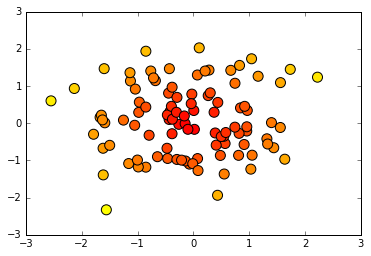

In [2]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5
pl.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='autumn')

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации

In [3]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

Напишем функцию для обучения на данных, предсказания ответа для каждой точки решетки и визуализации результата

In [4]:
def plot_model(X, y, clf, proba=False):
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    pl.figure(figsize=(10, 7))
    pl.pcolormesh(xx, yy, predicted, cmap='autumn')
    pl.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap='autumn', alpha=0.7)
    return clf

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

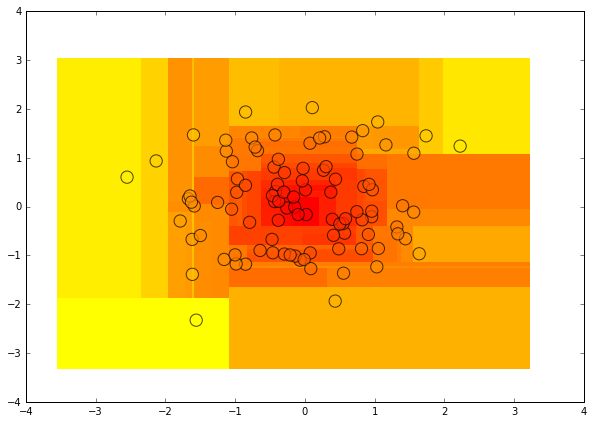

In [5]:
from sklearn.tree import DecisionTreeRegressor
plot_model(data_x, data_y, DecisionTreeRegressor())

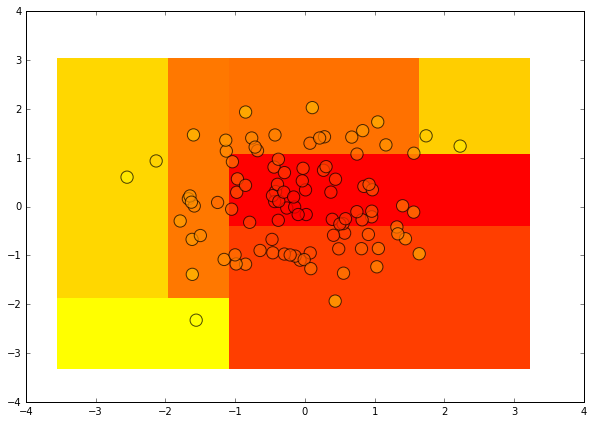

In [6]:
clf = plot_model(data_x, data_y, DecisionTreeRegressor(max_depth=3))

Визуализируем структуру дерева

In [7]:
import IPython.display #needed to render in notebook
import StringIO 
import pydot
from sklearn import tree

def draw_decision_tree(clf, column_names):
    dot_data = StringIO.StringIO() 
    tree.export_graphviz(clf, out_file=dot_data, feature_names=column_names) 
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    a = IPython.display.Image(graph.create_png())
    IPython.display.display(a)

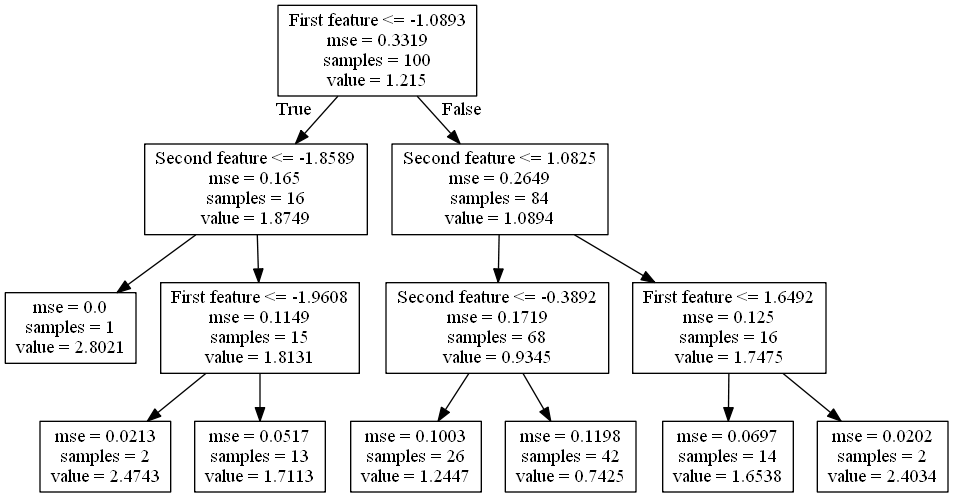

In [8]:
draw_decision_tree(clf, ['First feature', 'Second feature'])

Посмотрим, как меняется картинка для различных значений структурных параметров. Можно увидеть, что увеличение глубины дерева и уменьшение количества объектов в листьях способствует гибкости модели и, как следствие, переобучению (что соответствует интуитивным соображениям о структуре дерева).

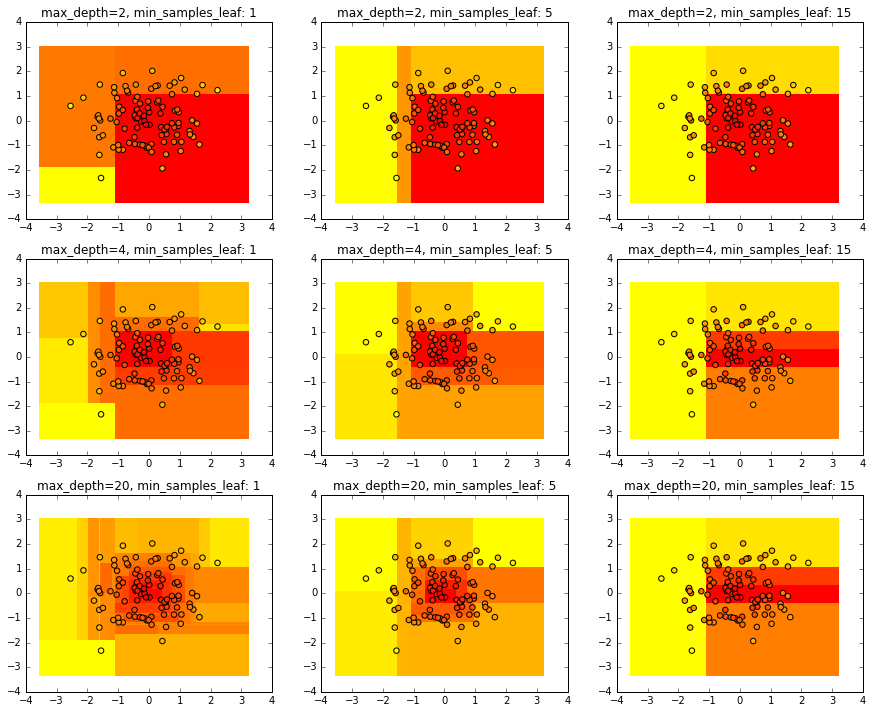

In [9]:
pl.figure(figsize=(15.0, 12.0))
for i, max_depth in enumerate([2, 4, 20]):
    for j, min_samples_leaf in enumerate([1, 5, 15]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        pl.pcolormesh(xx, yy, predicted, cmap='autumn')
        pl.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='autumn')
        title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

### Решающие деревья для классификации

Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.


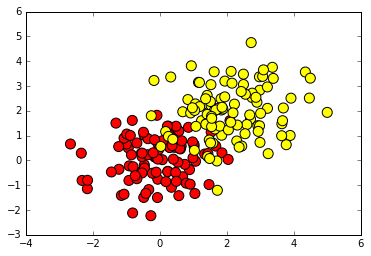

In [10]:
#first class
data_x = np.random.normal(size=(100, 2))
data_y = np.zeros(100)

#add second class
data_x = np.r_[data_x, np.random.normal(size=(100, 2), loc=2)]
data_y = np.r_[data_y, np.ones(100)]

pl.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='autumn')

Попробуем разделить эти два класса, обучив решающее дерево. Визуализируем полученную границу разделения класссов.

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

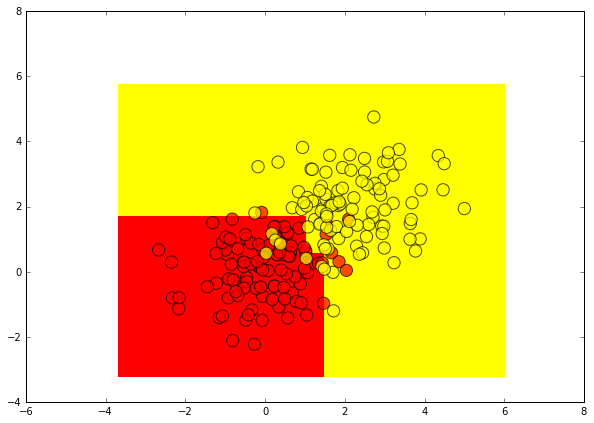

In [11]:
from sklearn.tree import DecisionTreeClassifier
plot_model(data_x, data_y, DecisionTreeClassifier(min_samples_leaf=5))

Проведем ту же процедуру, но теперь предскажем вещественные вероятности принадлежности первому классу.

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

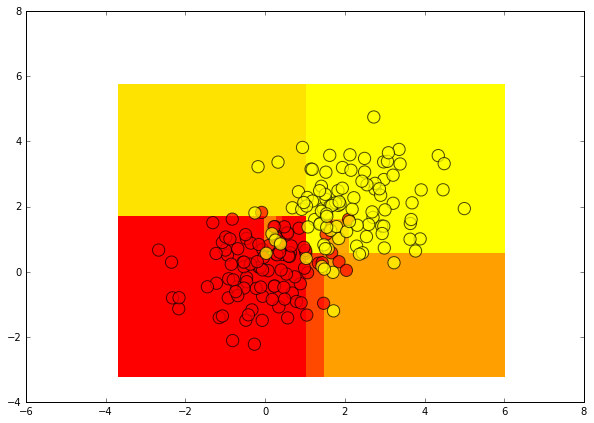

In [12]:
plot_model(data_x, data_y, DecisionTreeClassifier(min_samples_leaf=5), proba=True)

Оценим, как различные параметры влияют на качество. Проведем небольшую кроссвалидацию для максимальной глубины дерева и минимального количества объектов в листе. Выведем наилучшую конфигурацию и значения качества для каждой конфигурации.

In [13]:


param_grid = [{'max_depth': [2, 3, 5, 10], 'min_samples_leaf': [1, 3, 7, 20]}]

from sklearn.grid_search import GridSearchCV
searcher = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
searcher.fit(data_x, data_y)

print searcher.best_estimator_

for elem in searcher.grid_scores_: print elem



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
mean: 0.88500, std: 0.03391, params: {'max_depth': 2, 'min_samples_leaf': 1}
mean: 0.88500, std: 0.03391, params: {'max_depth': 2, 'min_samples_leaf': 3}
mean: 0.87500, std: 0.03536, params: {'max_depth': 2, 'min_samples_leaf': 7}
mean: 0.83000, std: 0.04848, params: {'max_depth': 2, 'min_samples_leaf': 20}
mean: 0.88500, std: 0.04637, params: {'max_depth': 3, 'min_samples_leaf': 1}
mean: 0.88000, std: 0.04000, params: {'max_depth': 3, 'min_samples_leaf': 3}
mean: 0.87500, std: 0.03536, params: {'max_depth': 3, 'min_samples_leaf': 7}
mean: 0.83000, std: 0.04848, params: {'max_depth': 3, 'min_samples_leaf': 20}
mean: 0.89500, std: 0.05788, params: {'max_depth': 5, 'min_samples_leaf': 1}
mean: 0.84500, std: 0.02915, param